In [1]:
import socket
import ipywidgets as widgets
from IPython.display import display

In [2]:
def test_gqrx_connection(host='localhost', port=7356):
    try:
        # Create a socket and connect to Gqrx
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.connect((host, port))

        # Send a command to get the frequency
        s.sendall(b'f\n')
        frequency = s.recv(1024).decode('utf-8').strip()

        s.close()
        return f'Connected successfully! Current frequency: {frequency} Hz'
    except Exception as e:
        return f'Failed to connect: {e}'

In [3]:
    
class GqrxController:
    def __init__(self, host='localhost', port=7356):
        self.host = host
        self.port = port
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.connect((self.host, self.port))

    def send_command(self, cmd):
        self.sock.sendall((cmd + '\n').encode('utf-8'))
        response = self.sock.recv(1024).decode('utf-8').strip()
        return response

    def get_frequency(self):
        return float(self.send_command('f'))

    def set_frequency(self, freq):
        self.send_command(f'F {freq}')
        return self.get_frequency()

    def close(self):
        self.sock.close()


In [4]:

# Test the connection
test_gqrx_connection()

# Create an instance of GqrxController
gqrx = GqrxController()

# Define a function to update frequency
def update_frequency(freq):
    gqrx.set_frequency(freq)
    print(f"Frequency set to: {freq} Hz")


In [5]:

# Create a slider for frequency control
freq_slider = widgets.FloatSlider(
    value=gqrx.get_frequency(),
    min=2.3e9,  # 2.3 GHz
    max=2.5e9,  # 2.5 GHz
    step=1e6,  # 1 MHz step
    description='Frequency:',
    continuous_update=False
)
widgets.interactive(update_frequency, freq=freq_slider)


interactive(children=(FloatSlider(value=2404571500.0, continuous_update=False, description='Frequency:', max=2…

In [6]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt

In [8]:
p = pyaudio.PyAudio()

print("Available audio devices:")
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    print(f"Index: {i}, Name: {device_info['name']}, Channels: {device_info['maxInputChannels']}, Sample Rate: {device_info['defaultSampleRate']}")


Available audio devices:
Index: 0, Name: l e t h e x (2) Microphone, Channels: 1, Sample Rate: 48000.0
Index: 1, Name: BlackHole 16ch, Channels: 16, Sample Rate: 44100.0
Index: 2, Name: BlackHole 2ch, Channels: 2, Sample Rate: 48000.0
Index: 3, Name: External Headphones, Channels: 0, Sample Rate: 48000.0
Index: 4, Name: MacBook Air Microphone, Channels: 1, Sample Rate: 44100.0
Index: 5, Name: MacBook Air Speakers, Channels: 0, Sample Rate: 44100.0
Index: 6, Name: MJAudioRecorder, Channels: 2, Sample Rate: 48000.0
Index: 7, Name: Microsoft Teams Audio, Channels: 2, Sample Rate: 48000.0
Index: 8, Name: Serato Virtual Audio, Channels: 2, Sample Rate: 48000.0
Index: 9, Name: rekordbox Aggregate Device, Channels: 0, Sample Rate: 0.0
Index: 10, Name: ZoomAudioDevice, Channels: 2, Sample Rate: 44100.0
Index: 11, Name: SC->Ableton->OBS, Channels: 18, Sample Rate: 48000.0
Index: 12, Name: SDR Monitor, Channels: 2, Sample Rate: 48000.0
Index: 13, Name: Stereo 2.1, Channels: 2, Sample Rate: 48000

In [15]:
def stream_audio():
    # Set up the audio stream
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=2, rate=48000, input=True, frames_per_buffer=1024, input_device_index=device_index)

    try:
        while True:
            try:
                # Read a chunk of audio data
                data = np.frombuffer(stream.read(1024, exception_on_overflow=False), dtype=np.int16)
            except OSError as e:
                if e.errno == -9981:
                    print("Input overflowed; skipping this chunk")
                    continue # Skip to the next iteration of the loop
                else:
                    raise e # Re-raise the exception if it's not an input overflow

            # Calculate the amplitude
            amplitude = np.abs(data).mean()

            # Perform a Fourier transform to get the frequency spectrum
            spectrum = np.fft.fft(data)
            freqs = np.fft.fftfreq(len(spectrum))
            magnitude = np.abs(spectrum)

            # Find the peak frequency
            peak_freq = np.abs(freqs[np.argmax(magnitude)])

            print(f"Frequency: {peak_freq} Hz, Amplitude: {amplitude}")

            # Optionally, plot the signal and frequency spectrum
            plt.subplot(2, 1, 1)
            plt.plot(data)
            plt.title("Signal")
            plt.subplot(2, 1, 2)
            plt.plot(freqs, magnitude)
            plt.title("Frequency Spectrum")
            plt.show()

    except KeyboardInterrupt:
        # Stop streaming on keyboard interrupt
        stream.stop_stream()
        stream.close()
        p.terminate()

    return


In [14]:
device_index = 2 # Replace with the index of the Aggregate Device or Multi-Output Device


Frequency: 0.453125 Hz, Amplitude: 4394.9638671875


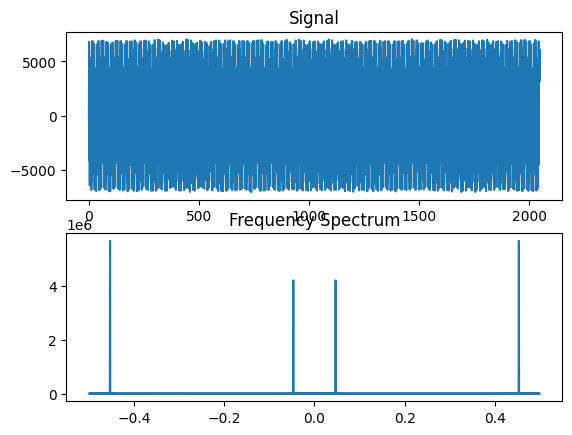

Frequency: 0.453125 Hz, Amplitude: 4359.6279296875


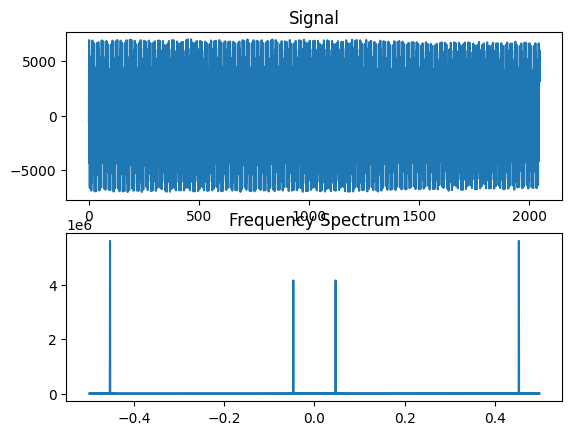

Frequency: 0.453125 Hz, Amplitude: 4286.103515625


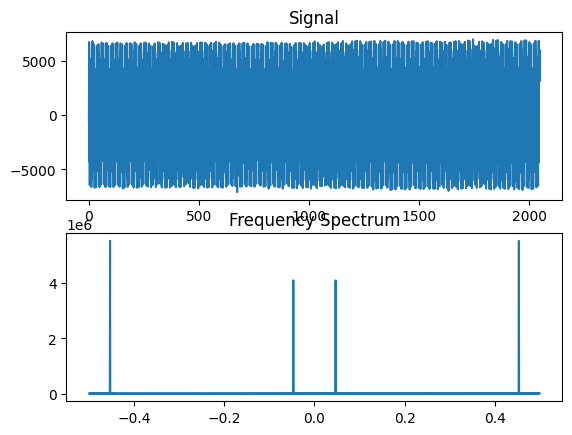

Frequency: 0.453125 Hz, Amplitude: 4336.53076171875


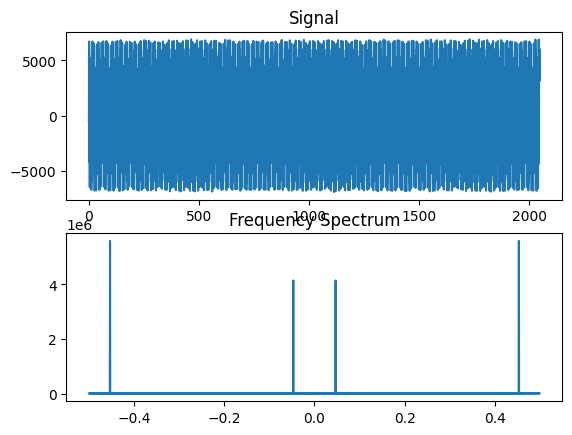

Frequency: 0.453125 Hz, Amplitude: 4349.212890625


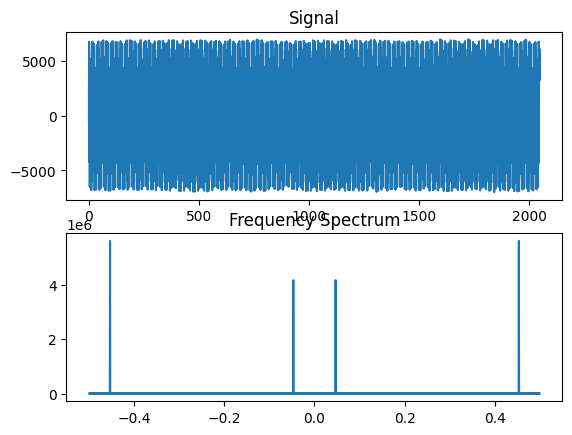

Frequency: 0.453125 Hz, Amplitude: 4371.37451171875


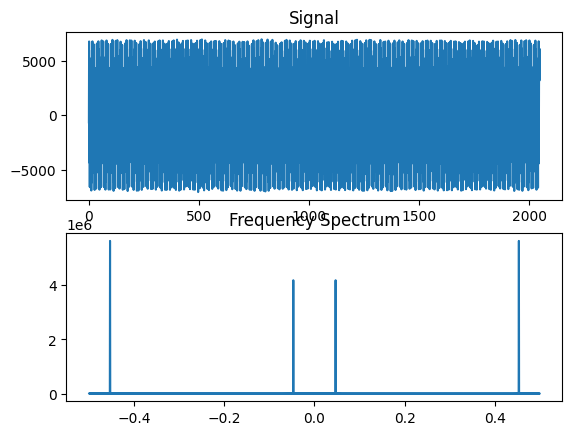

Frequency: 0.453125 Hz, Amplitude: 4386.58447265625


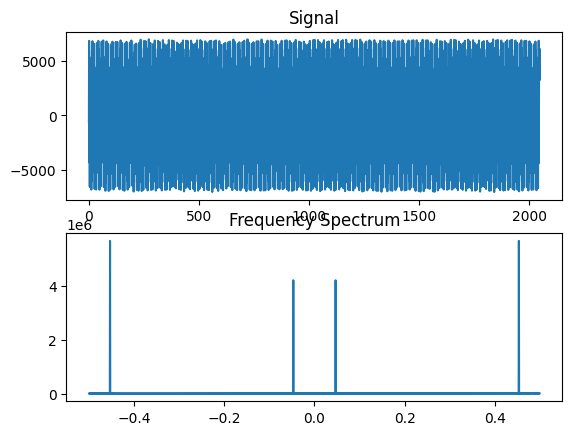

Frequency: 0.453125 Hz, Amplitude: 4300.2978515625


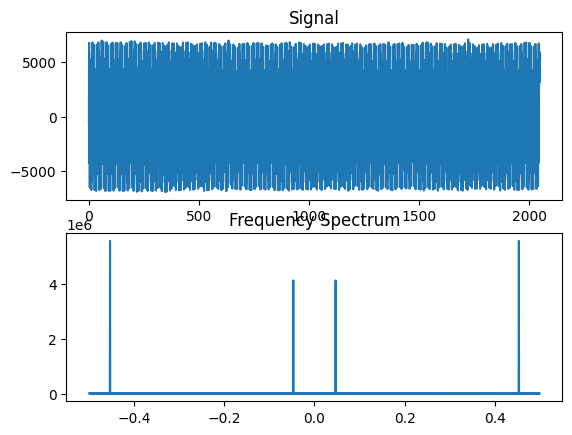

Frequency: 0.453125 Hz, Amplitude: 4367.3623046875


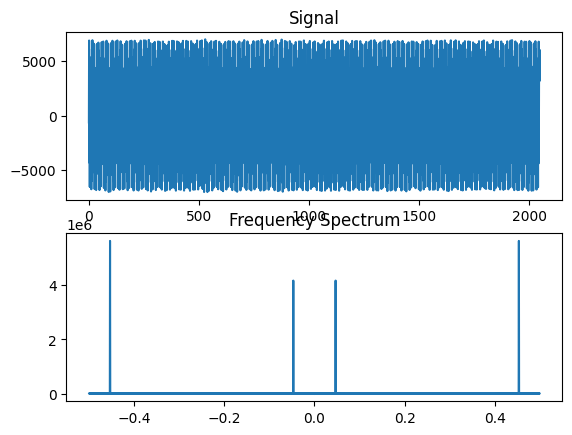

Frequency: 0.453125 Hz, Amplitude: 4378.06005859375


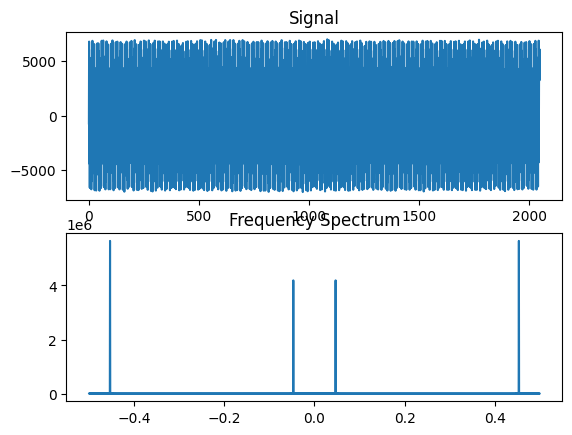

Frequency: 0.453125 Hz, Amplitude: 4361.7236328125


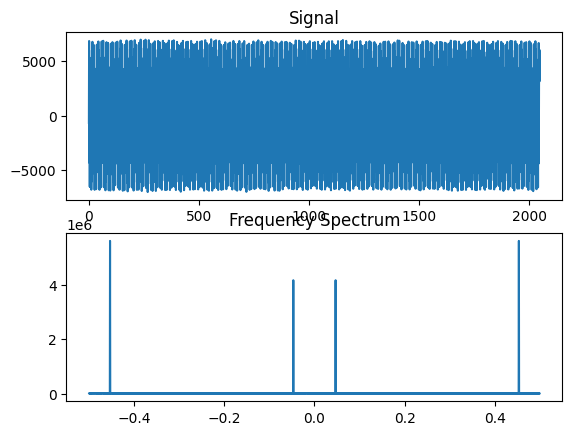

Frequency: 0.453125 Hz, Amplitude: 4406.9443359375


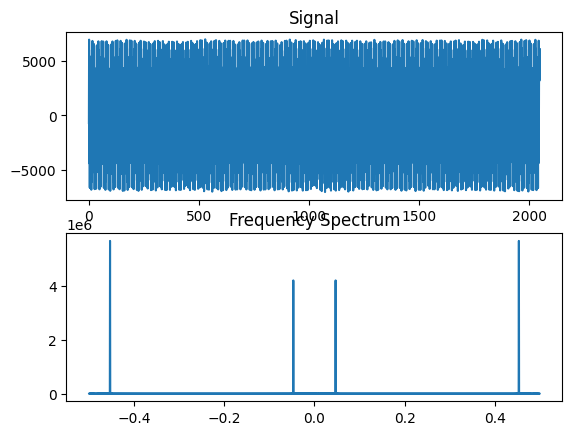

Frequency: 0.453125 Hz, Amplitude: 4313.97314453125


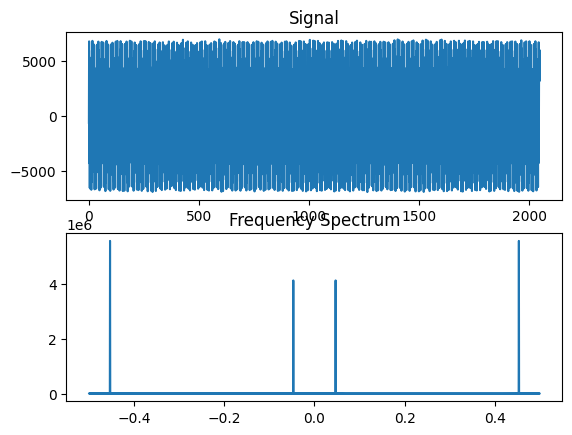

Frequency: 0.453125 Hz, Amplitude: 4265.36083984375


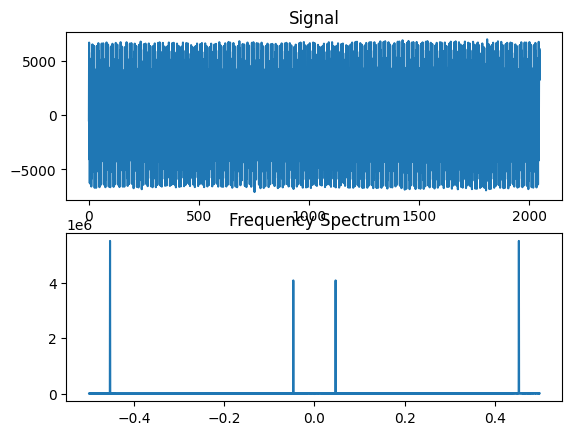

Frequency: 0.453125 Hz, Amplitude: 4376.779296875


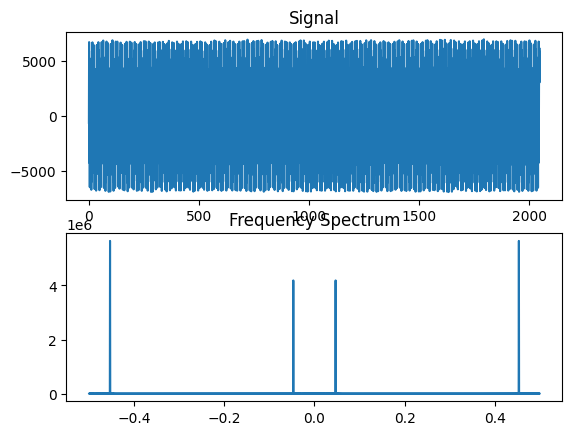

Frequency: 0.453125 Hz, Amplitude: 4378.9345703125


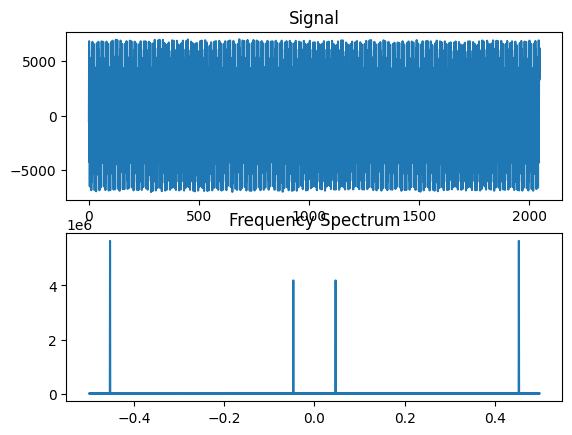

Frequency: 0.453125 Hz, Amplitude: 4360.0537109375


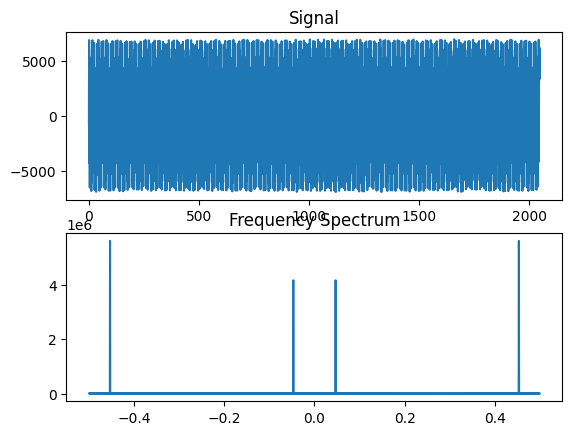

Frequency: 0.453125 Hz, Amplitude: 4368.70263671875


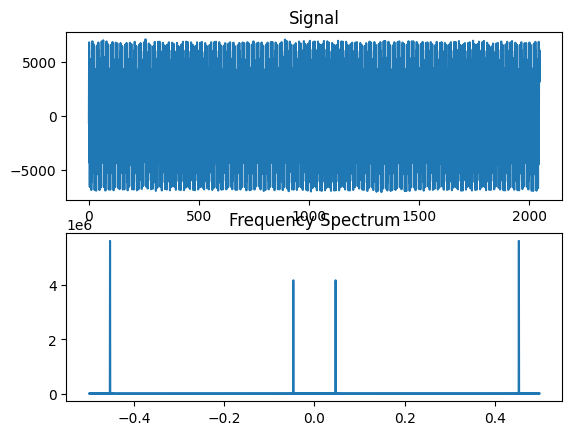

Frequency: 0.453125 Hz, Amplitude: 4197.814453125


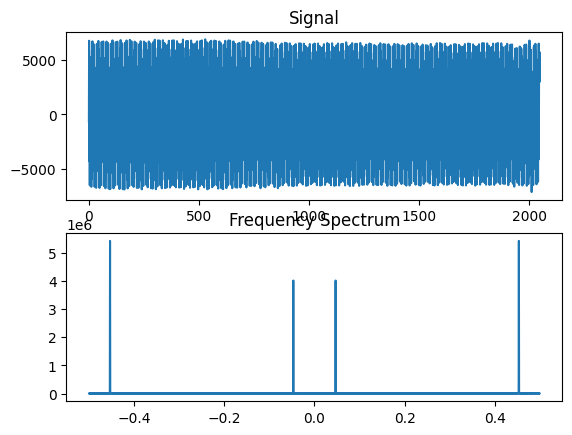

Frequency: 0.453125 Hz, Amplitude: 4375.1953125


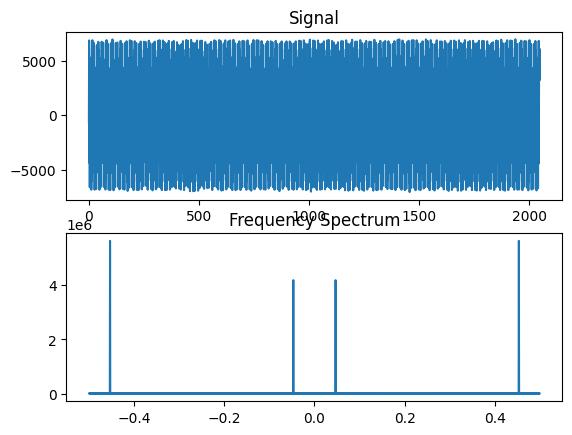

Frequency: 0.453125 Hz, Amplitude: 4350.6845703125


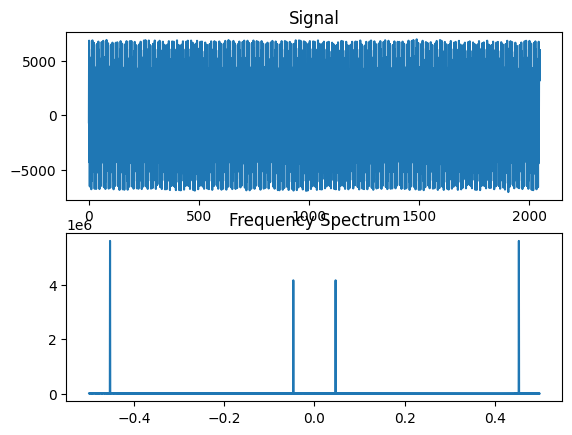

Frequency: 0.453125 Hz, Amplitude: 4382.625


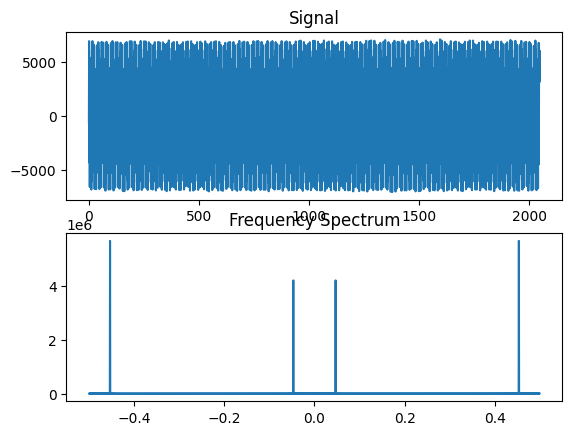

Frequency: 0.453125 Hz, Amplitude: 4391.68212890625


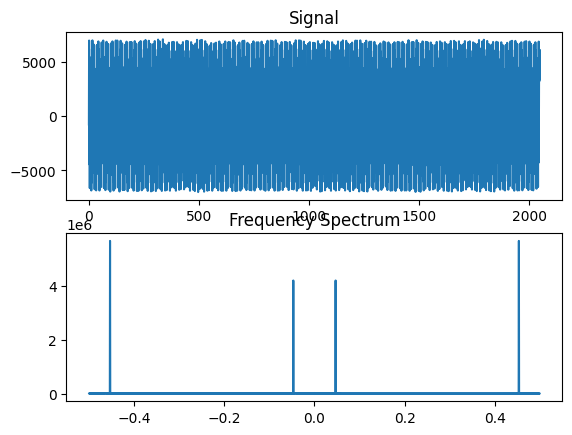

Frequency: 0.453125 Hz, Amplitude: 4353.94970703125


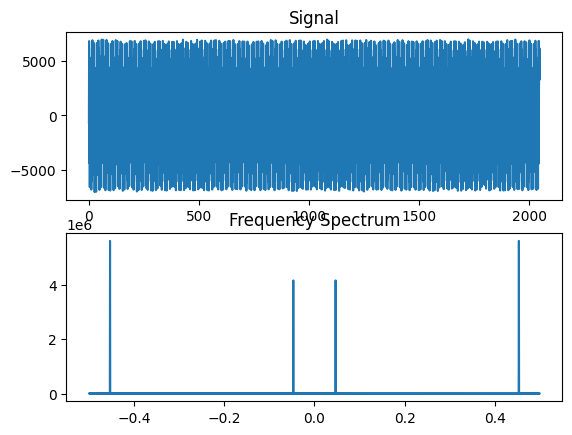

Frequency: 0.453125 Hz, Amplitude: 4391.35205078125


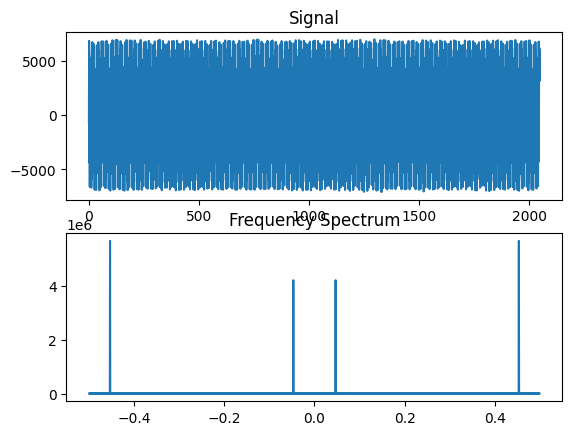

Frequency: 0.453125 Hz, Amplitude: 4398.32861328125


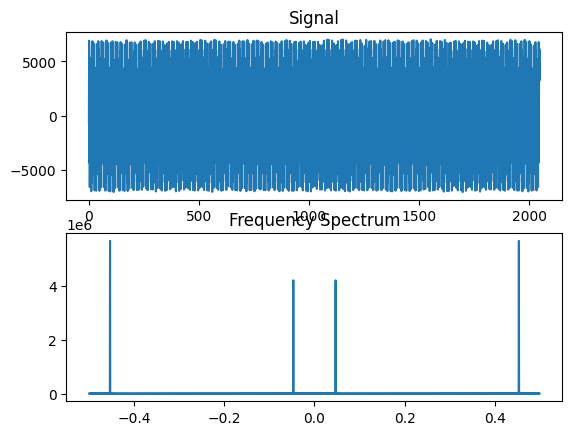

Frequency: 0.453125 Hz, Amplitude: 4351.0361328125


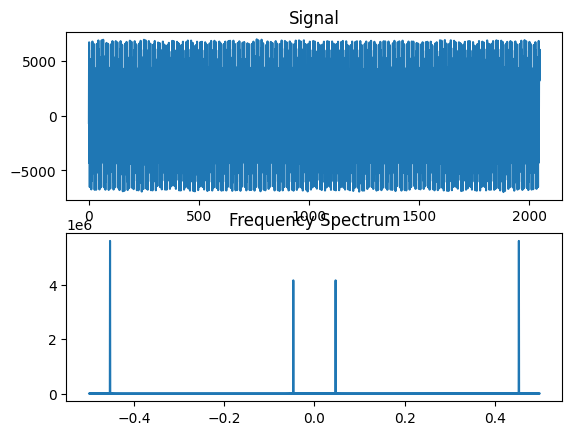

Frequency: 0.453125 Hz, Amplitude: 4387.93994140625


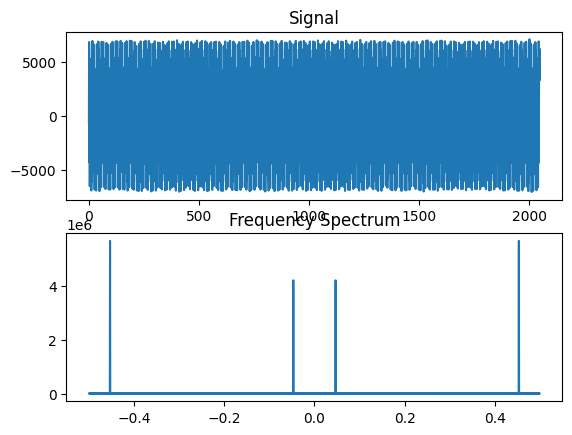

Frequency: 0.453125 Hz, Amplitude: 4327.67529296875


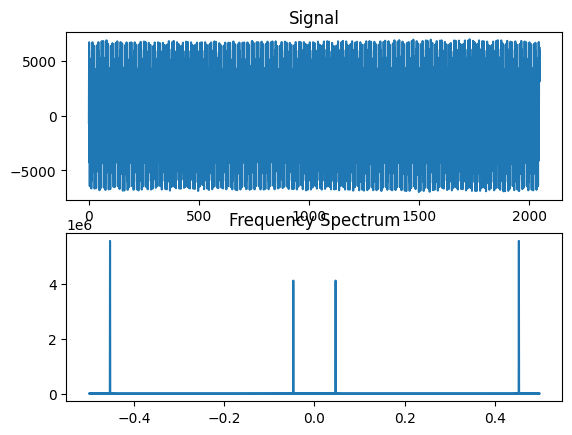

Frequency: 0.453125 Hz, Amplitude: 4397.29833984375


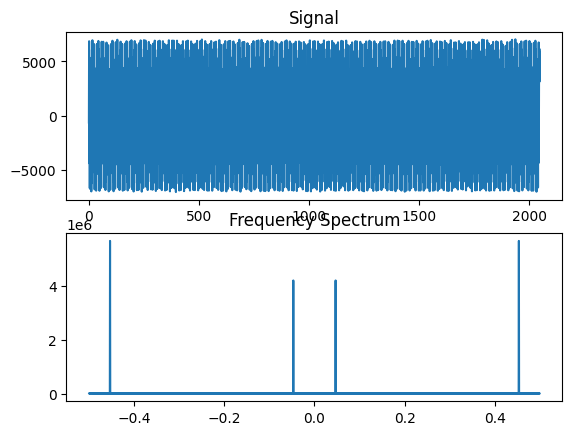

Frequency: 0.453125 Hz, Amplitude: 4383.26953125


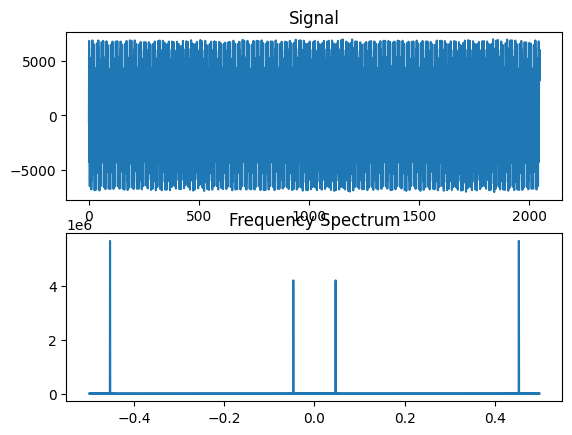

Frequency: 0.453125 Hz, Amplitude: 4390.91943359375


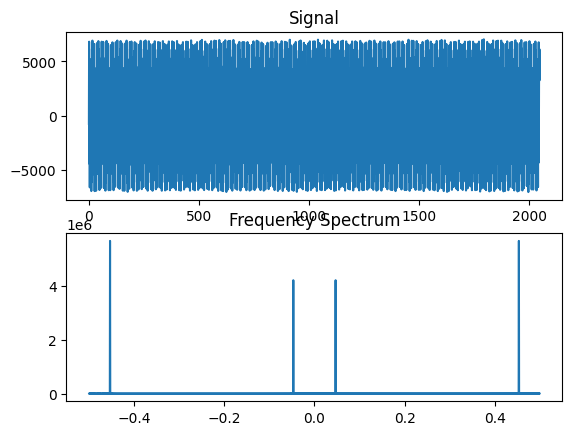

Frequency: 0.453125 Hz, Amplitude: 4357.59619140625


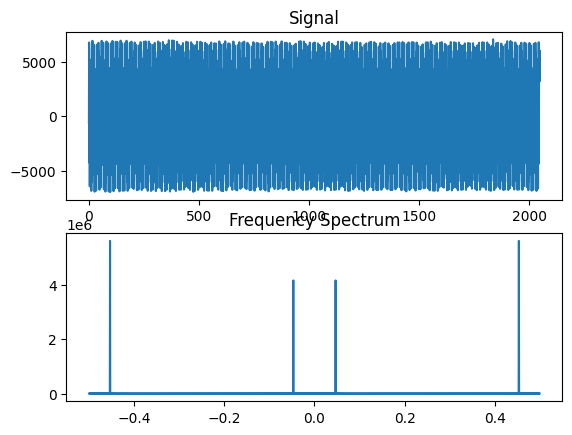

Frequency: 0.453125 Hz, Amplitude: 4375.01513671875


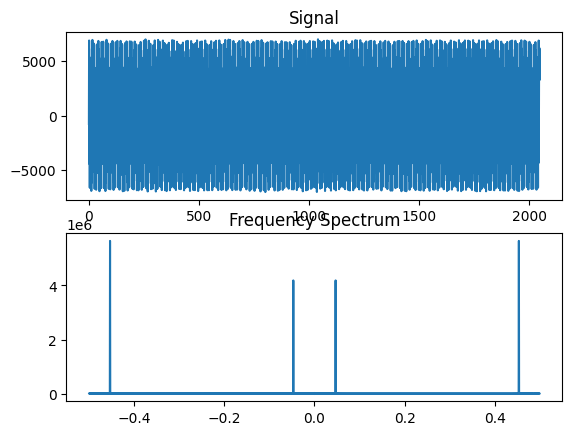

Frequency: 0.453125 Hz, Amplitude: 4337.2109375


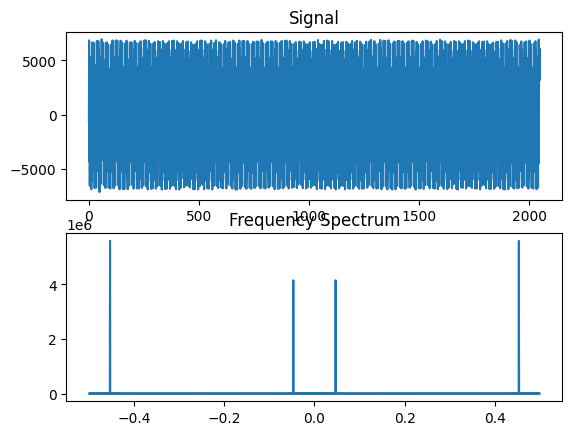

Frequency: 0.453125 Hz, Amplitude: 4391.0380859375


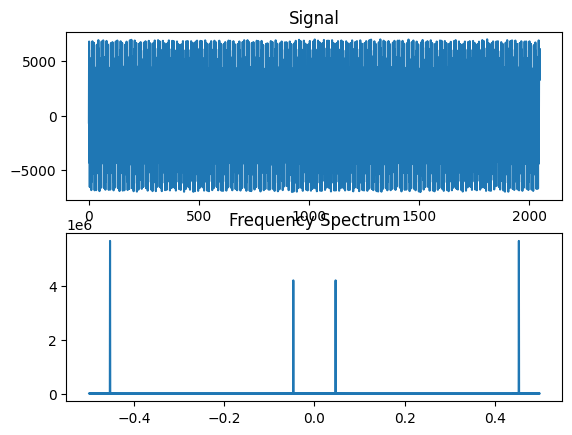

Frequency: 0.453125 Hz, Amplitude: 4391.61181640625


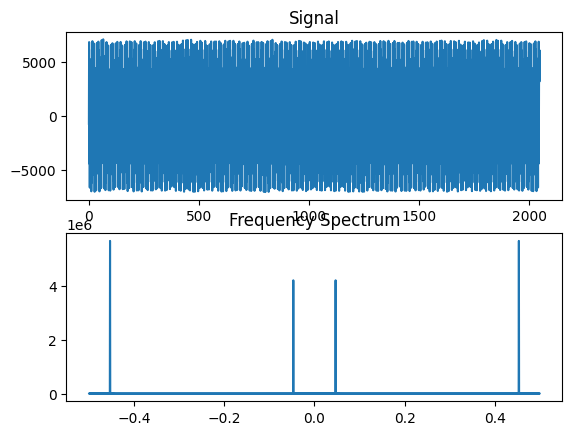

Frequency: 0.453125 Hz, Amplitude: 4375.02978515625


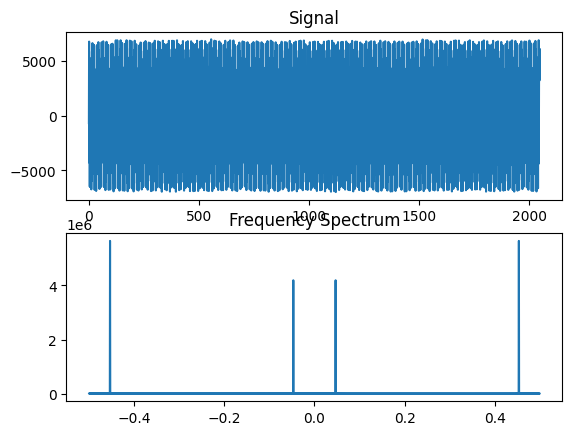

Frequency: 0.453125 Hz, Amplitude: 4402.39697265625


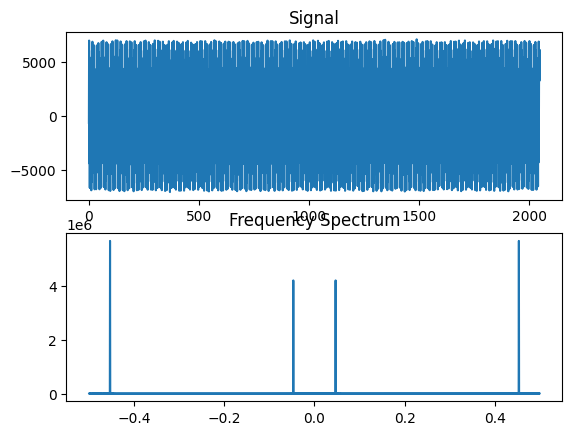

Frequency: 0.453125 Hz, Amplitude: 4390.55126953125


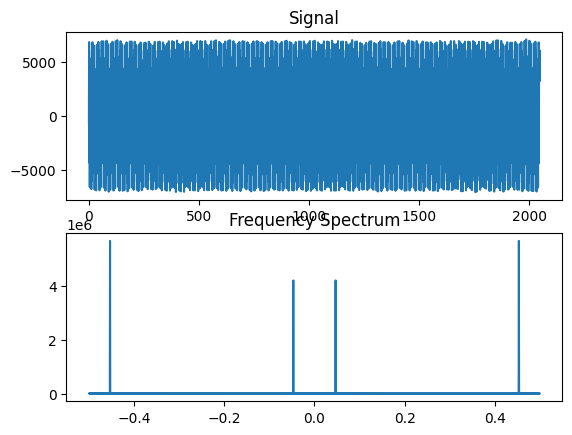

Frequency: 0.453125 Hz, Amplitude: 4386.9189453125


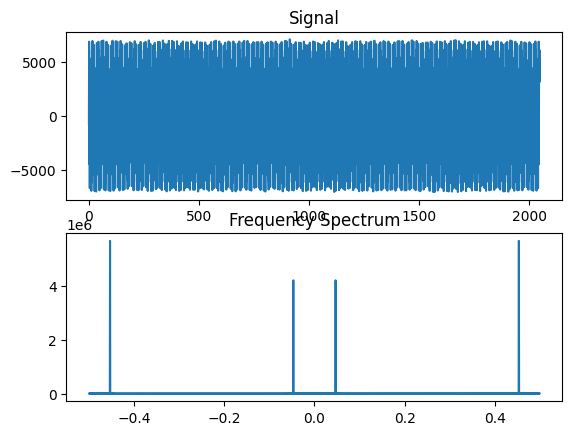

Frequency: 0.453125 Hz, Amplitude: 4364.03076171875


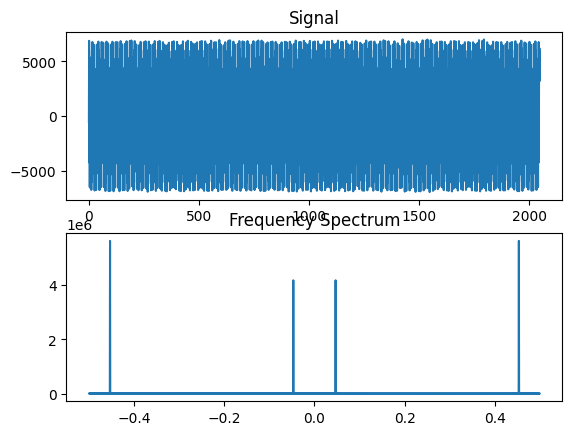

Frequency: 0.453125 Hz, Amplitude: 4378.8623046875


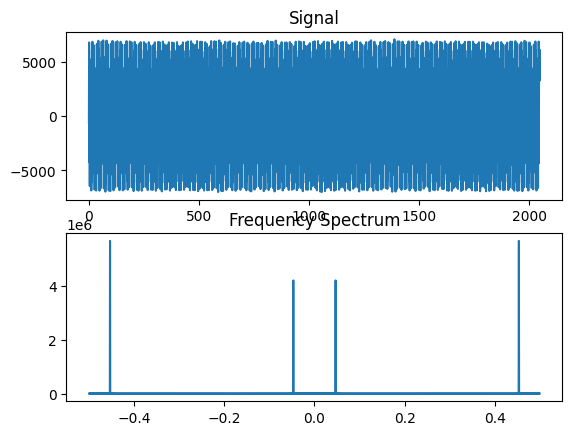

Frequency: 0.453125 Hz, Amplitude: 4363.83251953125


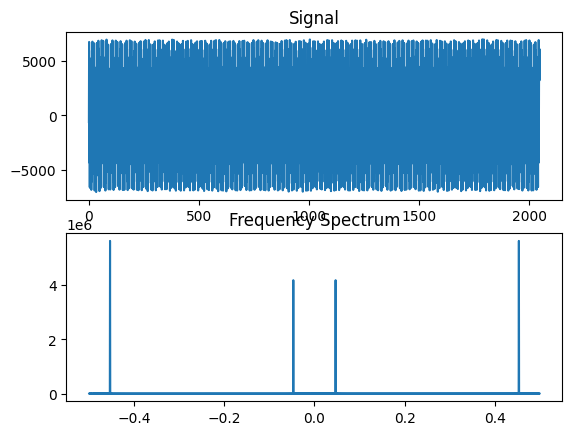

Frequency: 0.453125 Hz, Amplitude: 4393.76806640625


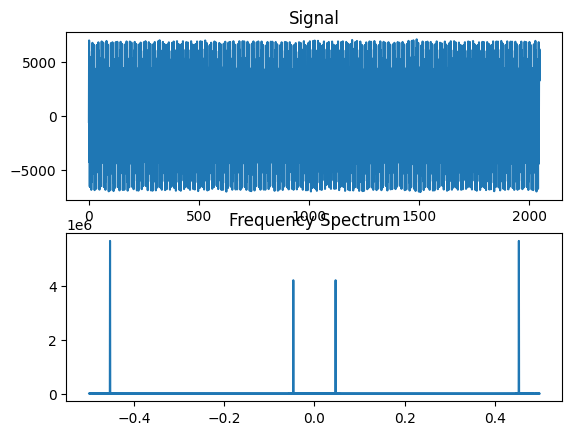

Frequency: 0.453125 Hz, Amplitude: 4403.24560546875


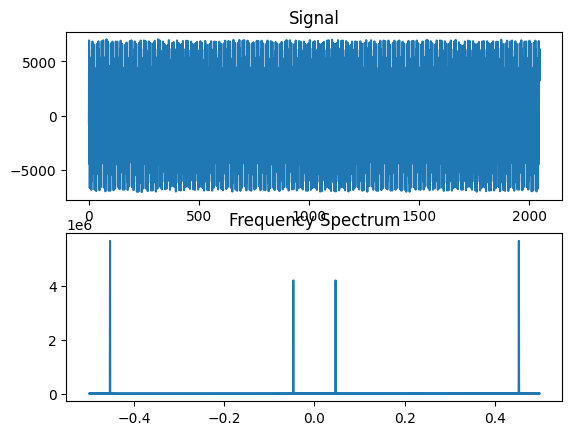

Frequency: 0.453125 Hz, Amplitude: 4388.57275390625


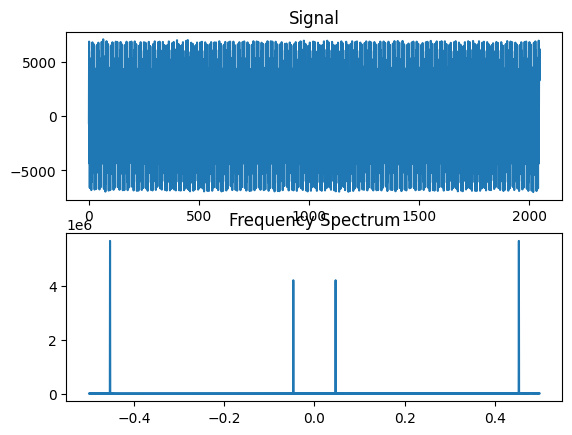

Frequency: 0.453125 Hz, Amplitude: 4324.462890625


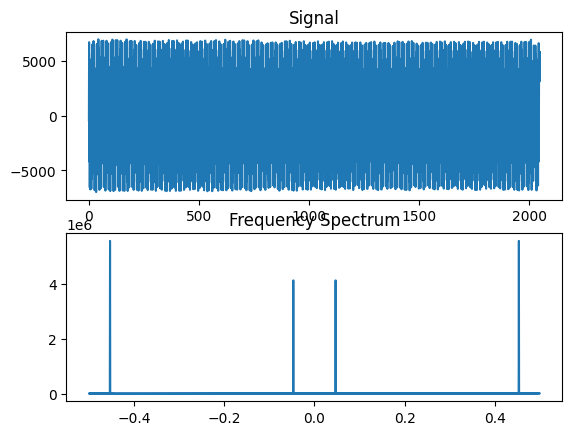

Frequency: 0.453125 Hz, Amplitude: 4358.89501953125


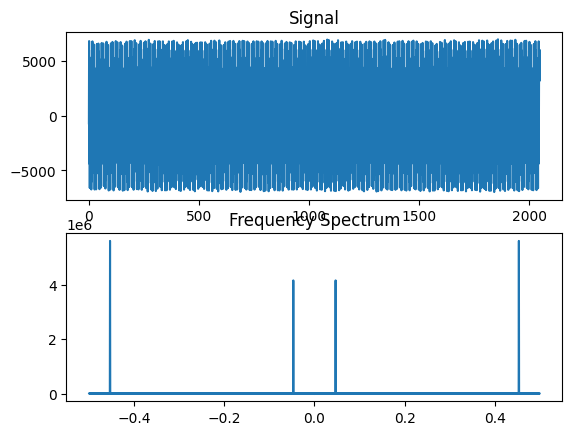

Frequency: 0.453125 Hz, Amplitude: 4359.67822265625


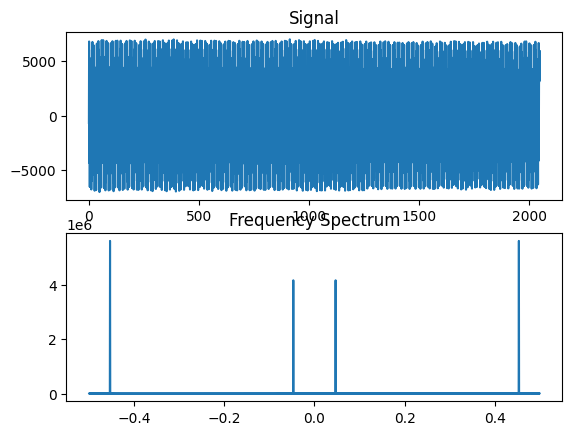

Frequency: 0.453125 Hz, Amplitude: 4351.85693359375


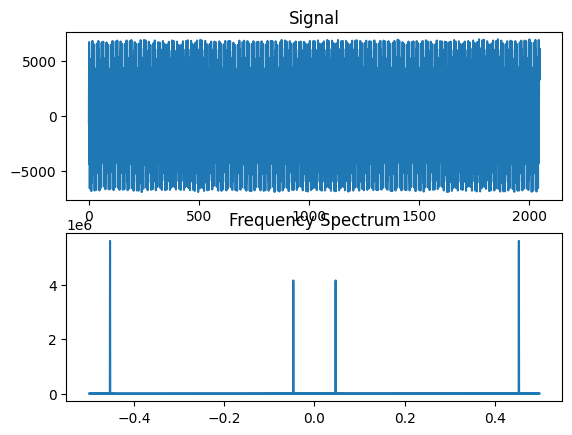

Frequency: 0.453125 Hz, Amplitude: 4387.00390625


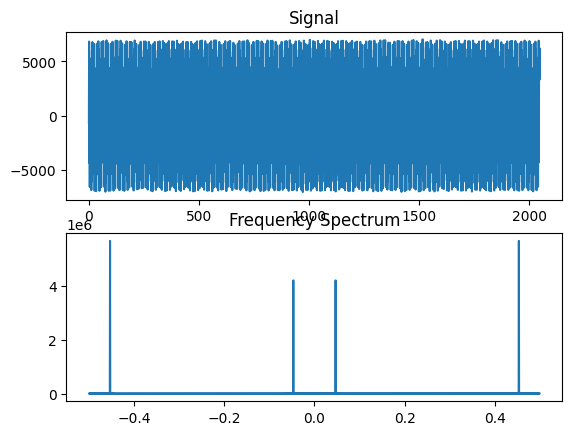

Frequency: 0.453125 Hz, Amplitude: 4357.07177734375


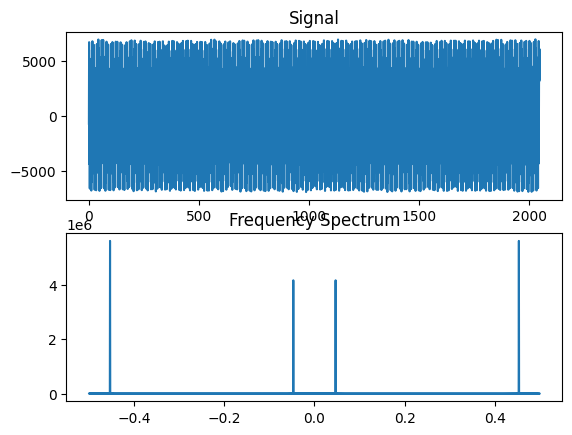

Frequency: 0.453125 Hz, Amplitude: 4331.25537109375


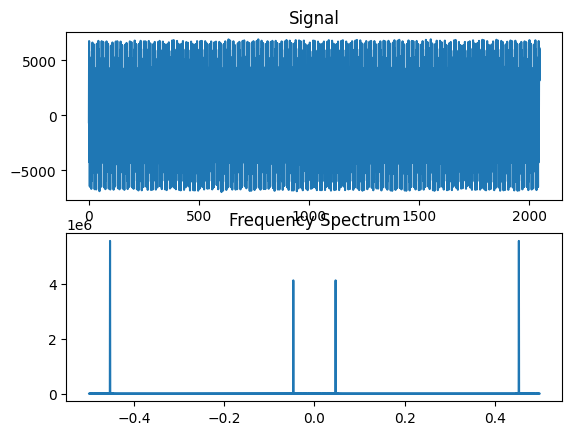

Frequency: 0.453125 Hz, Amplitude: 4376.978515625


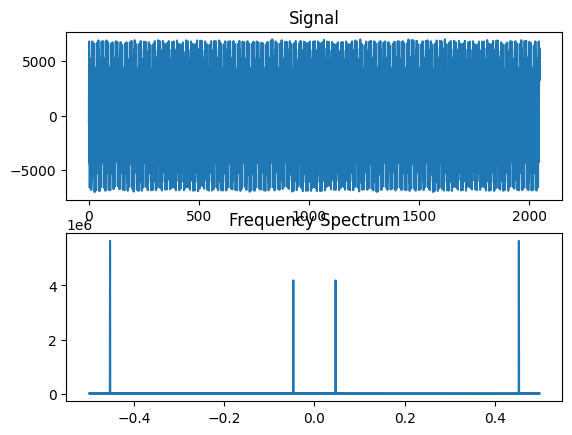

Frequency: 0.453125 Hz, Amplitude: 4391.69482421875


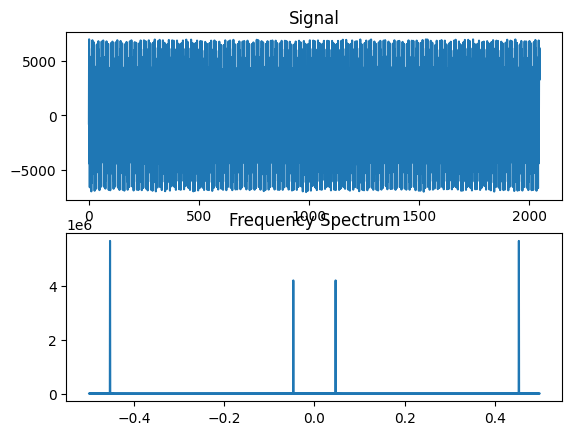

Frequency: 0.453125 Hz, Amplitude: 4391.220703125


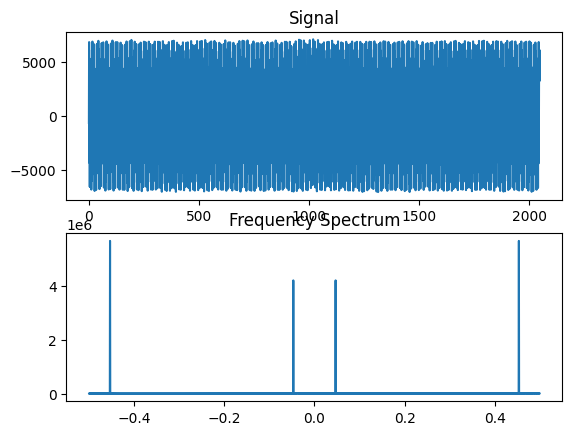

Frequency: 0.453125 Hz, Amplitude: 4394.3974609375


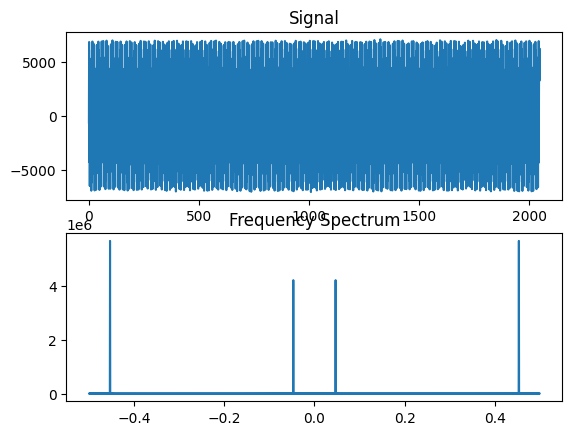

Frequency: 0.453125 Hz, Amplitude: 4196.87939453125


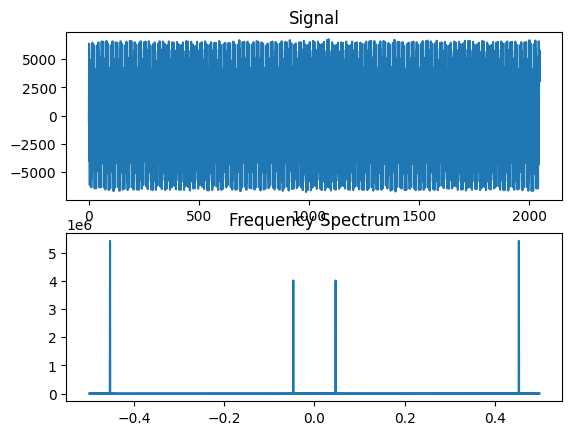

Frequency: 0.453125 Hz, Amplitude: 4356.01708984375


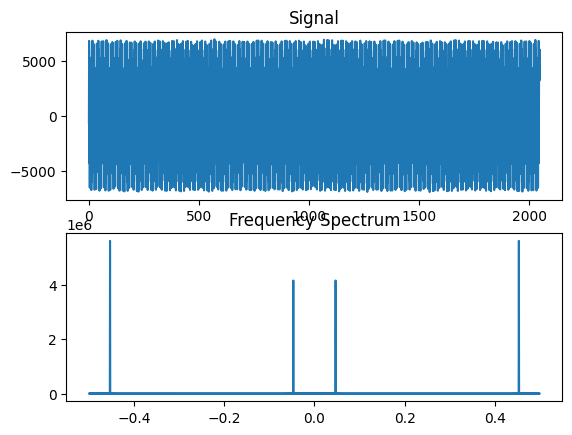

Frequency: 0.453125 Hz, Amplitude: 4369.14794921875


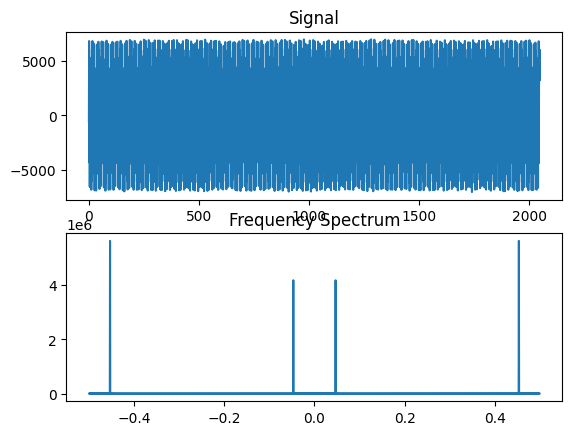

Frequency: 0.453125 Hz, Amplitude: 4288.86474609375


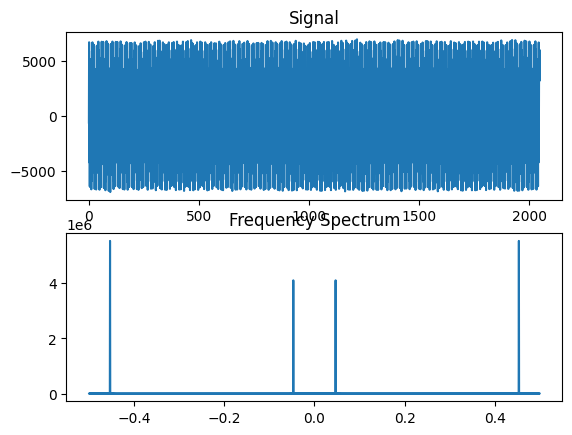

Frequency: 0.453125 Hz, Amplitude: 4371.22607421875


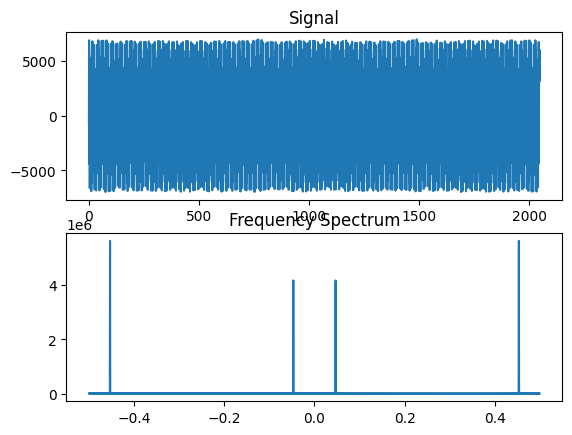

Frequency: 0.453125 Hz, Amplitude: 4389.98974609375


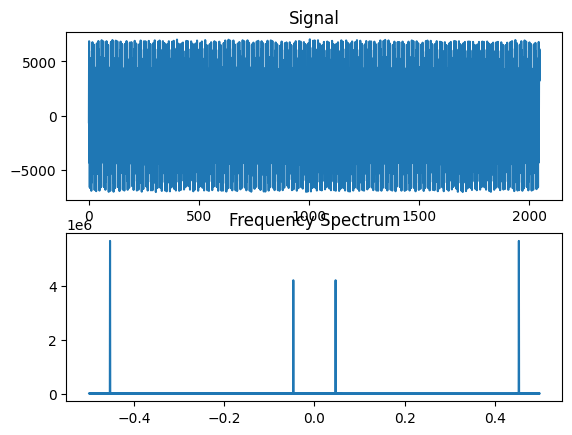

Frequency: 0.453125 Hz, Amplitude: 4398.57958984375


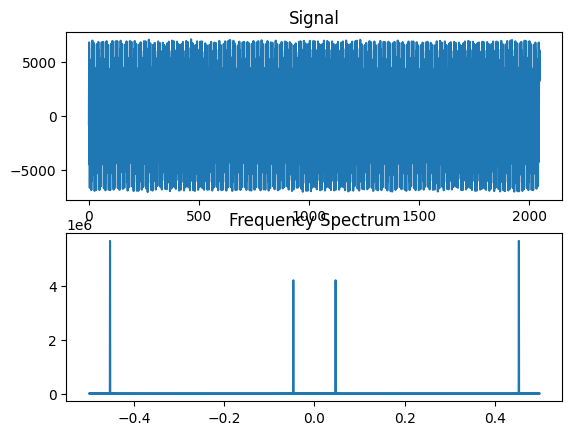

Frequency: 0.453125 Hz, Amplitude: 4365.755859375


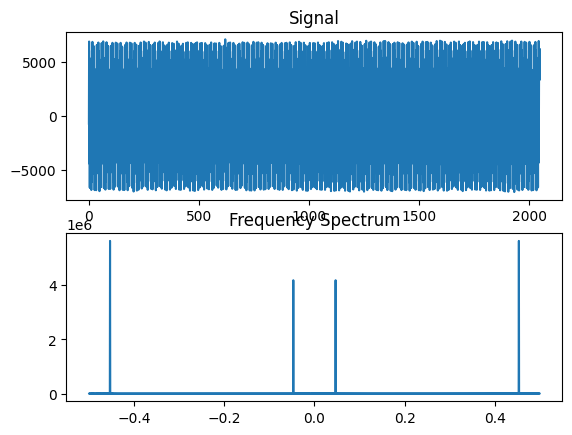

Frequency: 0.453125 Hz, Amplitude: 4362.4775390625


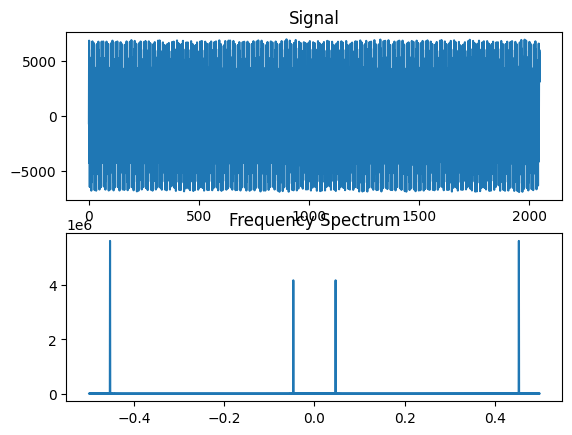

Frequency: 0.453125 Hz, Amplitude: 4402.8681640625


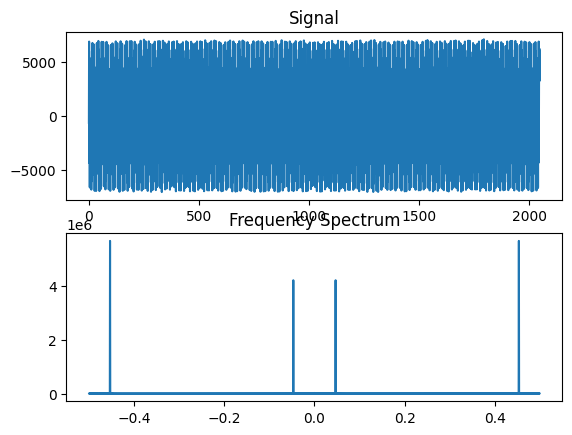

Frequency: 0.453125 Hz, Amplitude: 4372.0244140625


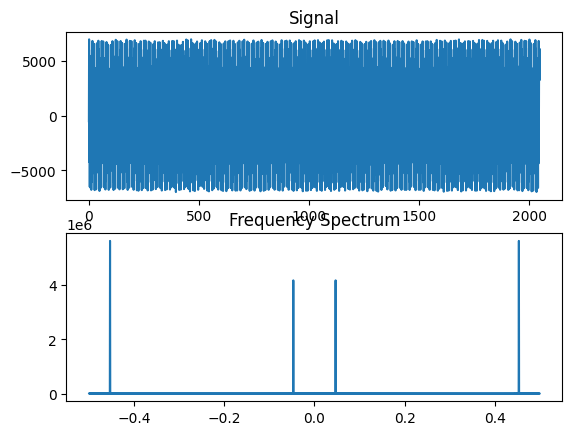

Frequency: 0.453125 Hz, Amplitude: 4394.5361328125


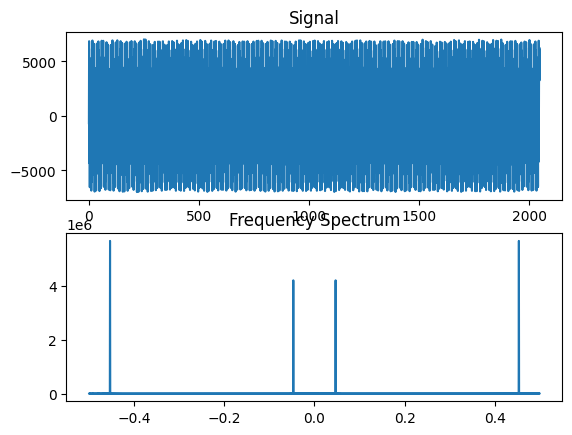

Frequency: 0.453125 Hz, Amplitude: 4337.75830078125


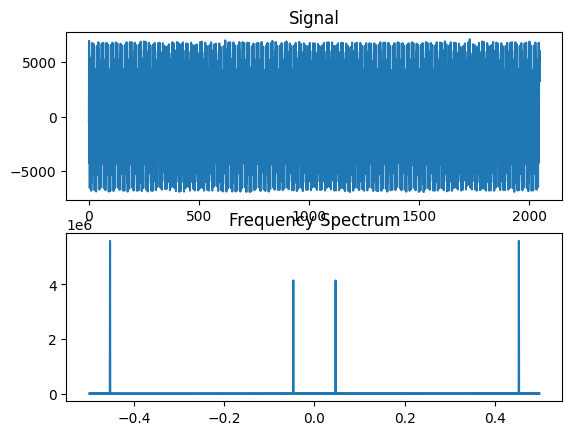

Frequency: 0.453125 Hz, Amplitude: 4337.79736328125


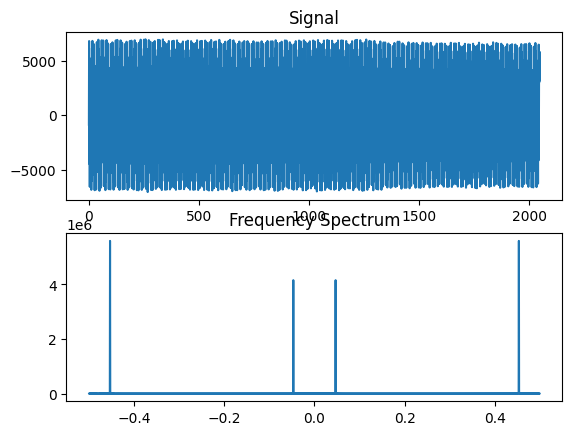

Frequency: 0.453125 Hz, Amplitude: 4379.94140625


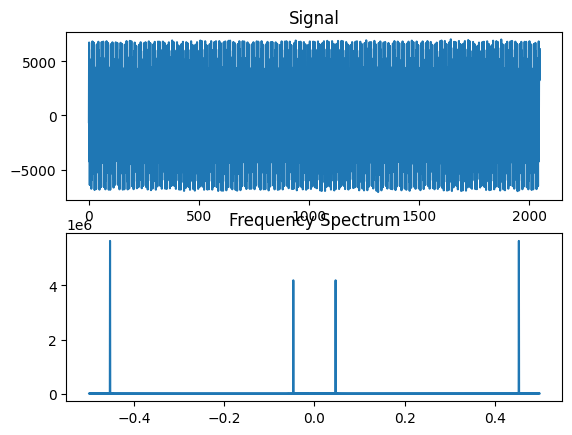

Frequency: 0.453125 Hz, Amplitude: 4401.720703125


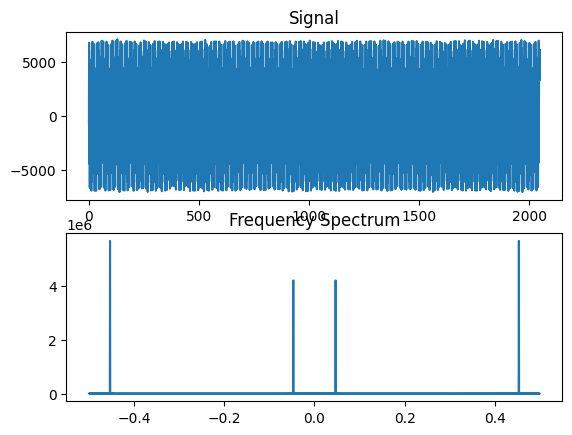

Frequency: 0.453125 Hz, Amplitude: 4369.32958984375


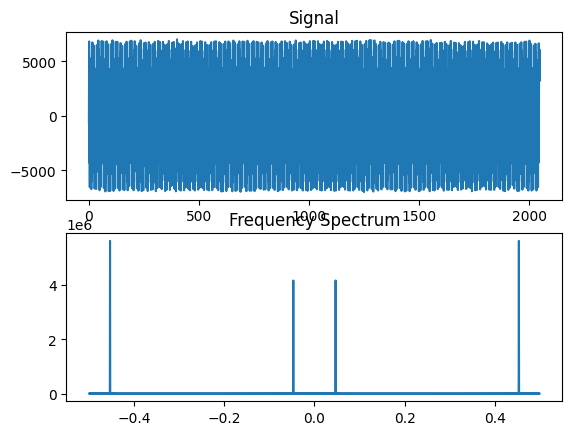

Frequency: 0.453125 Hz, Amplitude: 4164.515625


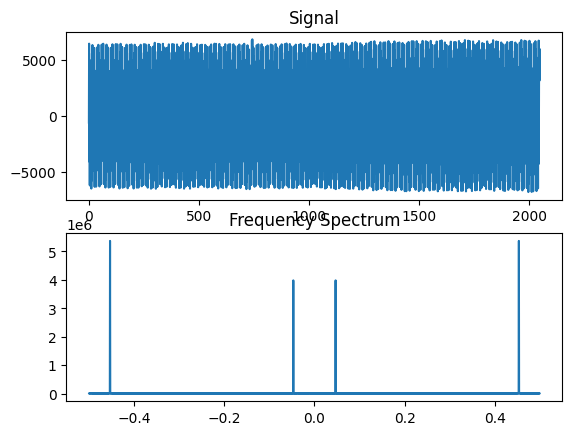

Frequency: 0.453125 Hz, Amplitude: 4329.76318359375


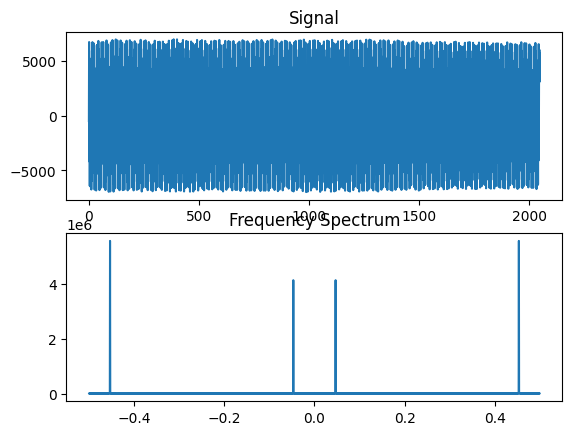

Frequency: 0.453125 Hz, Amplitude: 4345.35498046875


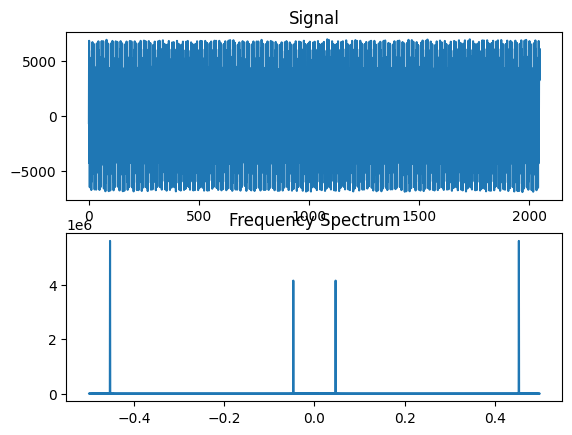

Frequency: 0.453125 Hz, Amplitude: 4395.94287109375


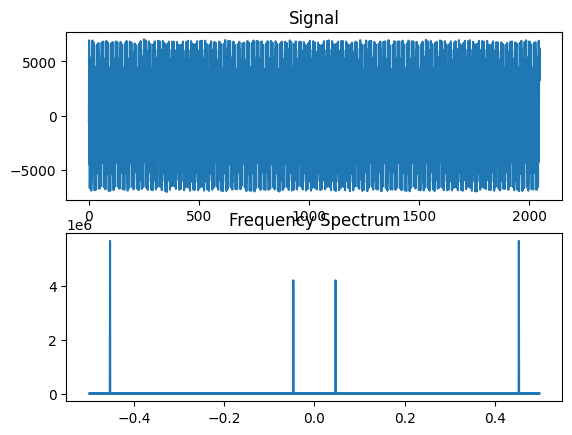

Frequency: 0.453125 Hz, Amplitude: 4387.49267578125


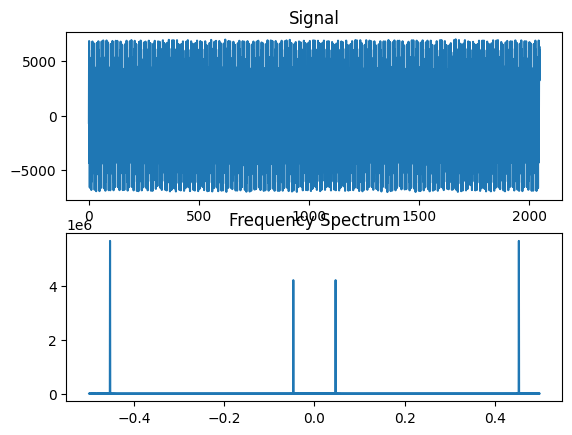

Frequency: 0.453125 Hz, Amplitude: 4379.25732421875


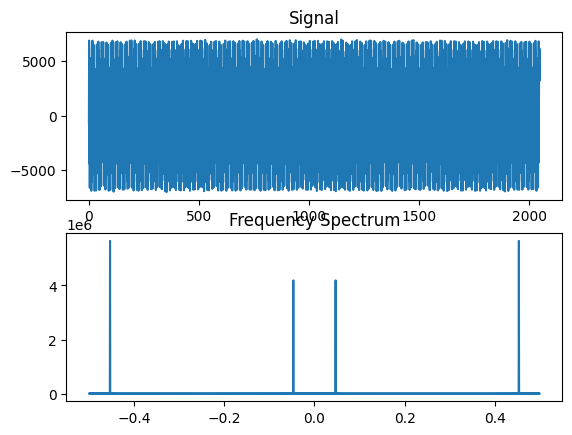

Frequency: 0.453125 Hz, Amplitude: 4382.986328125


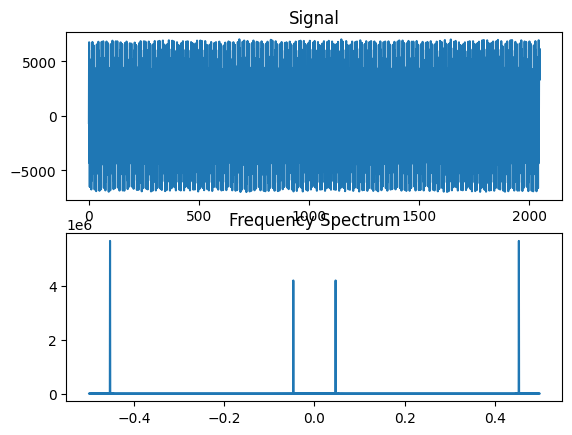

Frequency: 0.453125 Hz, Amplitude: 4342.724609375


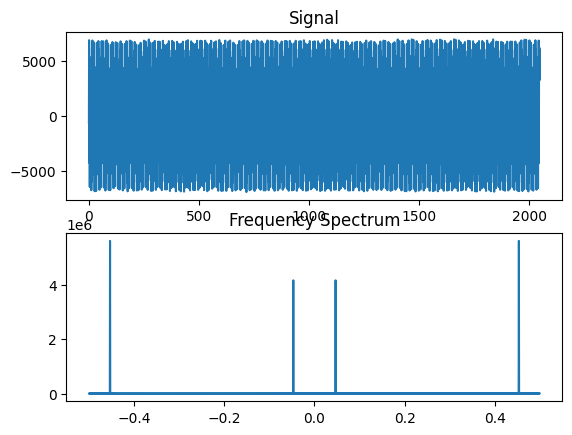

Frequency: 0.453125 Hz, Amplitude: 4402.6318359375


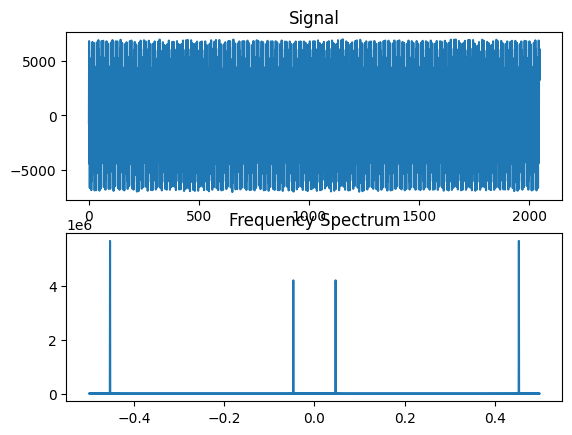

Frequency: 0.453125 Hz, Amplitude: 4388.1982421875


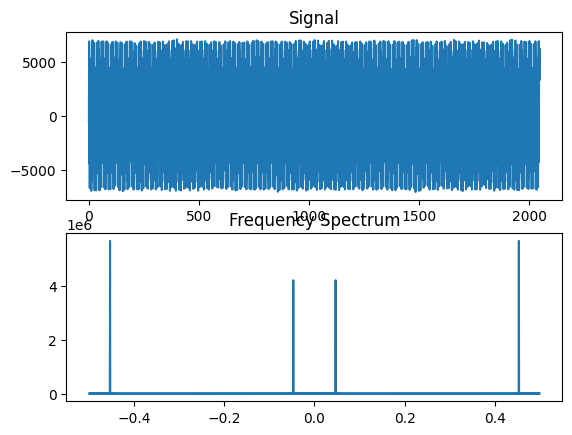

Frequency: 0.453125 Hz, Amplitude: 4344.220703125


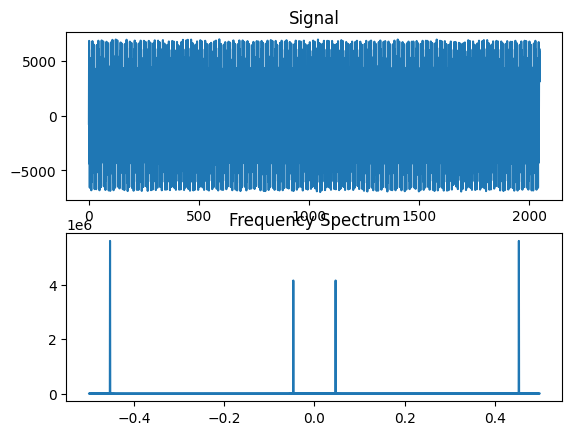

Frequency: 0.453125 Hz, Amplitude: 4287.90380859375


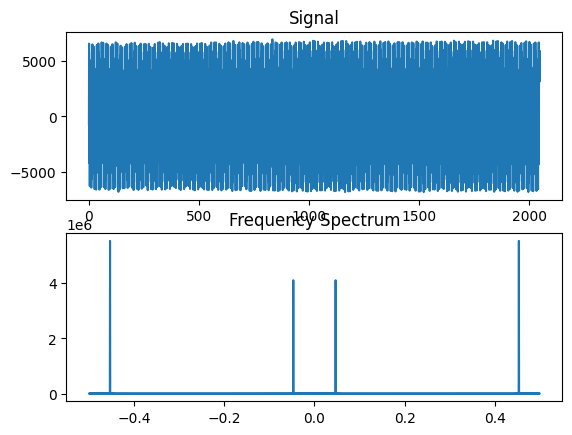

Frequency: 0.453125 Hz, Amplitude: 4386.2109375


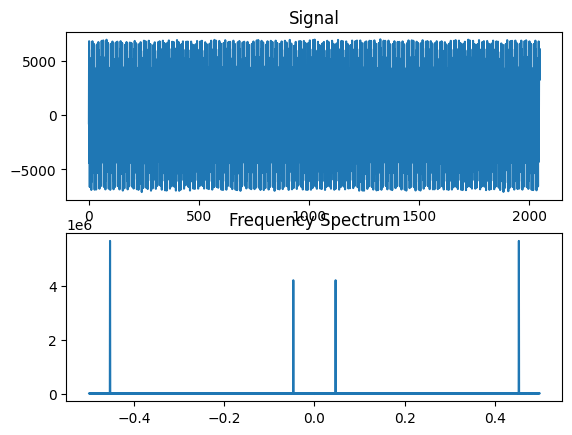

Frequency: 0.453125 Hz, Amplitude: 4338.17822265625


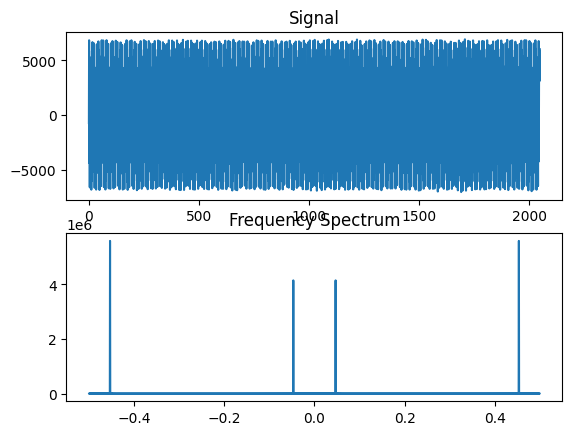

Frequency: 0.453125 Hz, Amplitude: 4371.9892578125


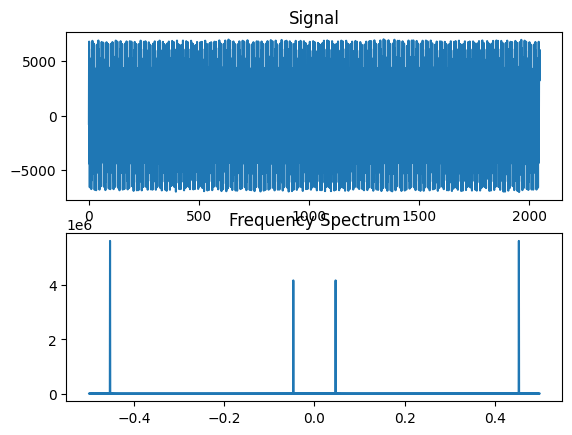

Frequency: 0.453125 Hz, Amplitude: 4384.25244140625


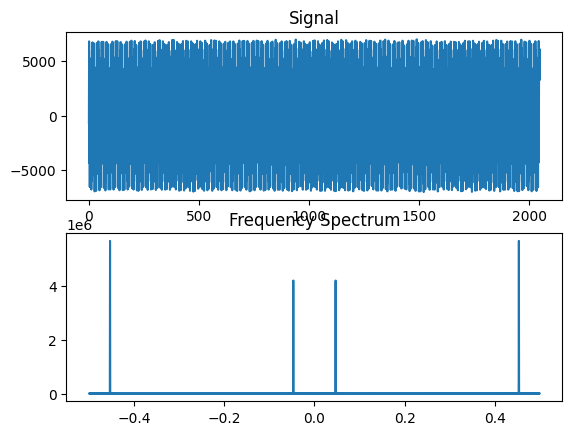

Frequency: 0.453125 Hz, Amplitude: 4390.74853515625


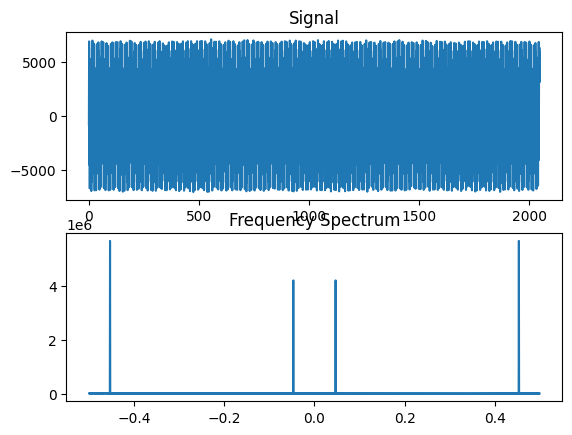

Frequency: 0.453125 Hz, Amplitude: 4373.01904296875


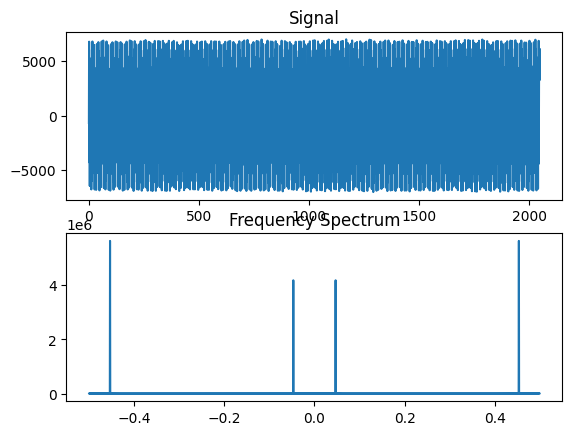

Frequency: 0.453125 Hz, Amplitude: 4403.26416015625


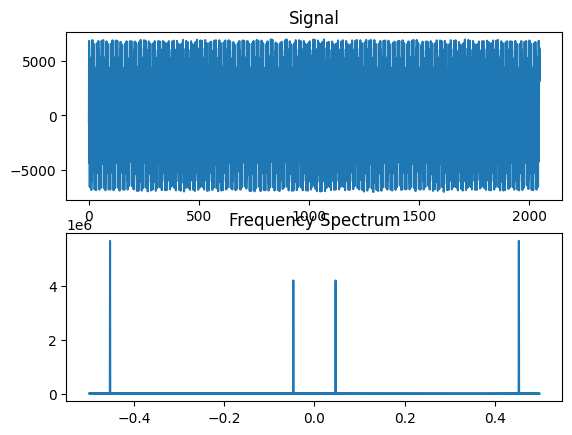

Frequency: 0.453125 Hz, Amplitude: 4380.21484375


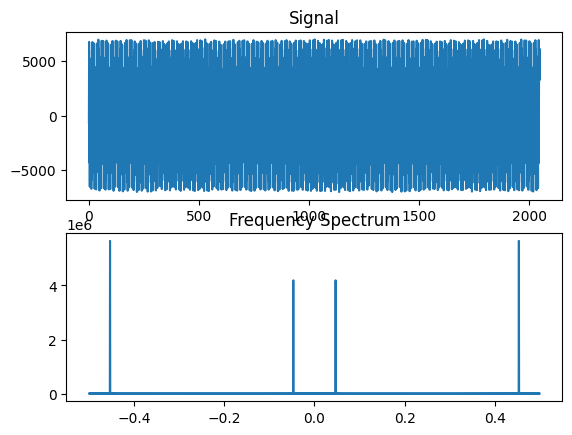

Frequency: 0.453125 Hz, Amplitude: 4397.01416015625


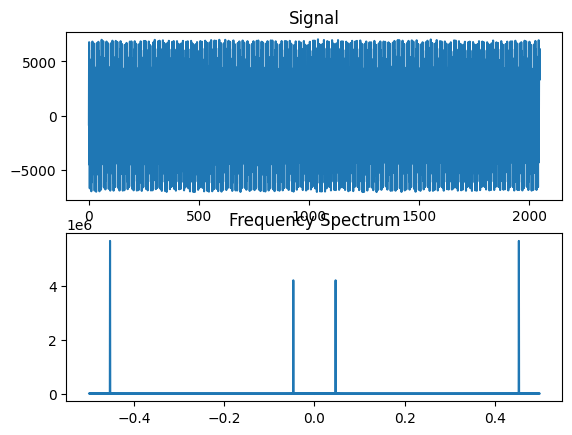

Frequency: 0.453125 Hz, Amplitude: 4290.6669921875


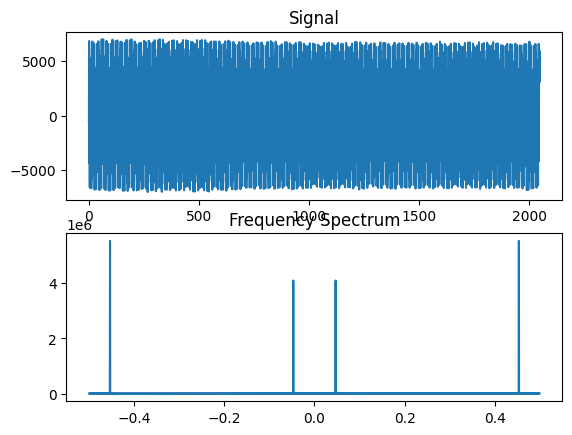

Frequency: 0.453125 Hz, Amplitude: 4329.15966796875


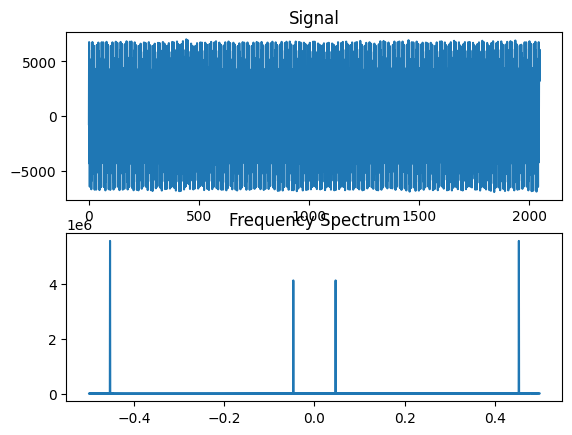

Frequency: 0.453125 Hz, Amplitude: 4340.65771484375


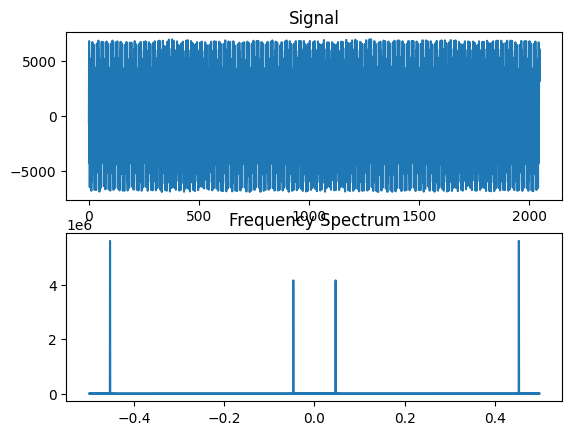

Frequency: 0.453125 Hz, Amplitude: 4345.3466796875


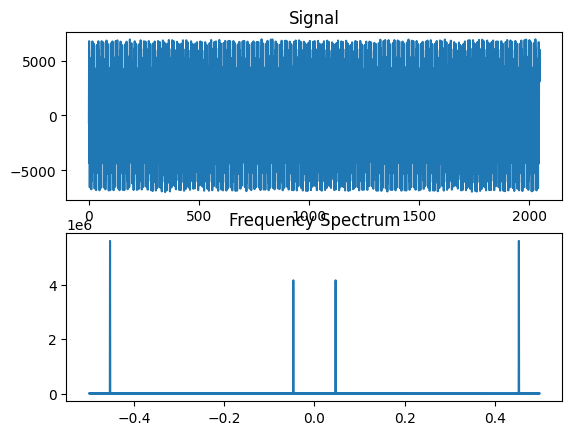

Frequency: 0.453125 Hz, Amplitude: 4337.78515625


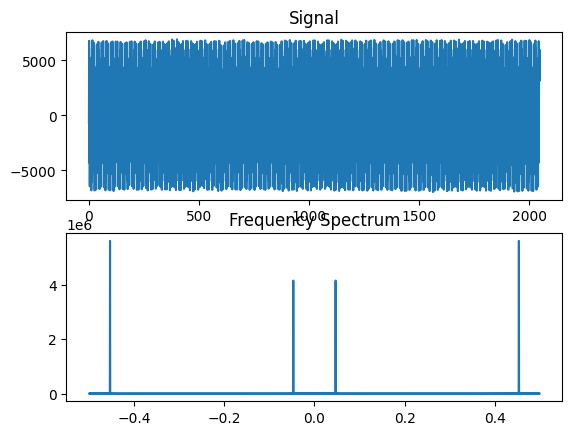

Frequency: 0.453125 Hz, Amplitude: 4239.01953125


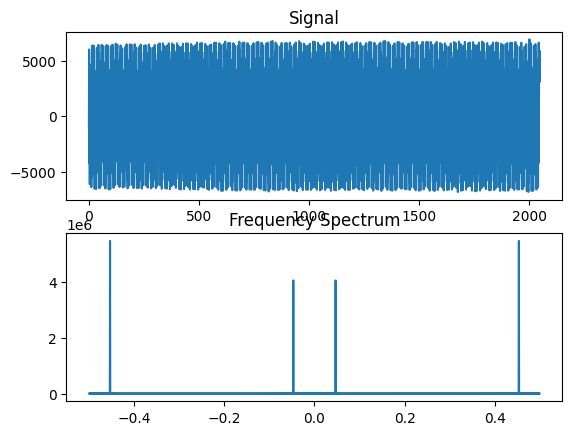

Frequency: 0.453125 Hz, Amplitude: 4361.6259765625


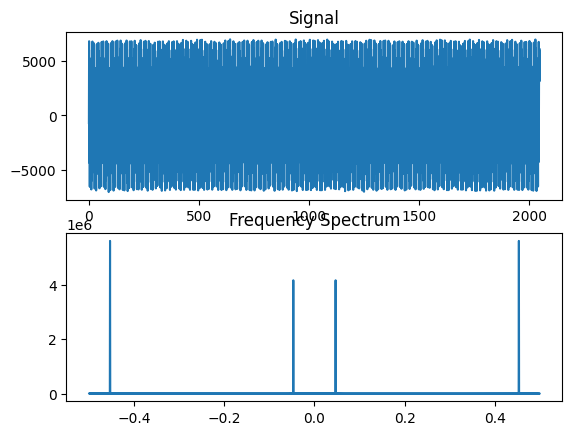

Frequency: 0.453125 Hz, Amplitude: 4340.74169921875


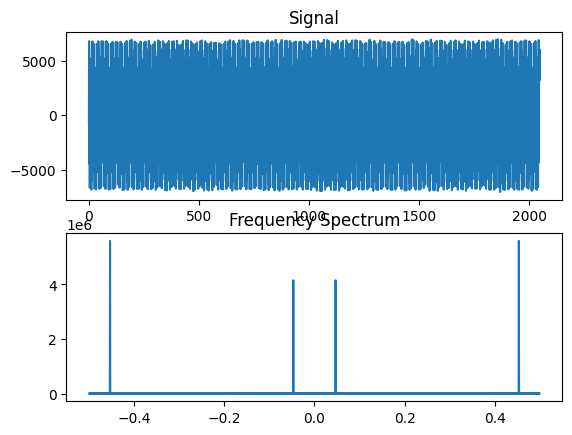

Frequency: 0.453125 Hz, Amplitude: 4390.630859375


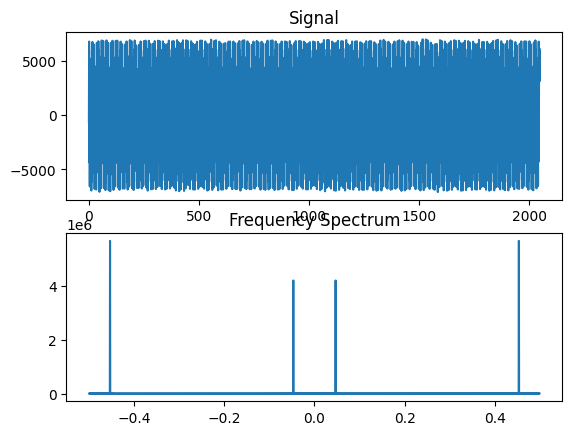

Frequency: 0.453125 Hz, Amplitude: 4386.05029296875


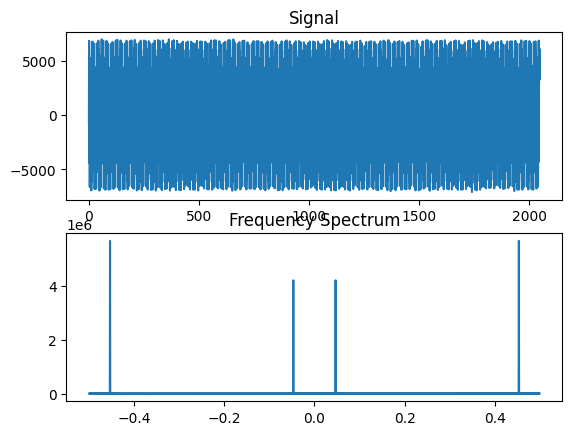

Frequency: 0.453125 Hz, Amplitude: 4374.19921875


<Figure size 640x480 with 0 Axes>

In [16]:
stream_audio()

In [10]:

stream = p.open(format=pyaudio.paInt16, channels=2, rate=48000, input=True, frames_per_buffer=1024, input_device_index=device_index)


In [ ]:
device_info = p.get_device_info_by_index(device_index)
sample_rate = int(device_info['defaultSampleRate'])

In [ ]:

# Close the connection
gqrx.close()
